In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# !pip install peft bitsandbytes -q
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
from transformers import BitsAndBytesConfig
from tqdm.auto import tqdm
from anycache import anycache
from peft import AutoPeftModelForCausalLM, get_peft_model, PeftConfig, PeftModelForCausalLM
import torch
from torch.utils.data import DataLoader

from open_pref_eval.plot.radar import radar_plot
from open_pref_eval.helpers.mem import clear_mem


torch.autograd.set_grad_enabled(False)


quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

In [3]:
model_name = "wassname/qwen-7B-codefourchan-QLoRA"
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", 
    torch_dtype=torch.bfloat16, 
    quantization_config=quantization_config
)
# wrap in peft
model = PeftModelForCausalLM.from_pretrained(
    model,
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
)
tokenizer = AutoTokenizer.from_pretrained(model.peft_config['default'].base_model_name_or_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [4]:
datasets = get_default_datasets(100)
datasets

[Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 })]

In [5]:
dataset = datasets[0]

In [6]:
from open_pref_eval.trainer import DataCollatorForPreference, concatenated_forward
max_prompt_length = 512
max_length = 1024
batch_size = 6

data_collator = DataCollatorForPreference(
    pad_token_id=tokenizer.pad_token_id,
    tokenizer=tokenizer,
    max_prompt_length=max_prompt_length,
    max_completion_length=max_length - max_prompt_length,
)
eval_dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    collate_fn=data_collator,
    num_workers=0,
    shuffle=False,
    drop_last=False,
)

for step, batch in enumerate(
    tqdm(eval_dataloader, desc=f"Eval")
):
    break

Eval:   0%|          | 0/17 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [58]:
import matplotlib as mpl
import numpy as np
from IPython.core.display import HTML

cmap = plt.get_cmap("coolwarm_r") 


def plot_logprobs(tokens, token_scores, mask=None):
    norm = mpl.colors.Normalize(vmin=np.nanmin(token_scores), vmax=np.nanmax(token_scores))


    # if it's log middle is np.log(0.5)
    # norm = mpl.colors.LogNorm(vmin=min(token_scores), vmax=max(token_scores))
    # norm = mpl.colors.CenteredNorm(
    #     # vmin=min(token_scores), 
    #     halfrange=max(abs(token_scores))
    # )
    # print(min(token_scores), max(token_scores))
    
    # TODO html color map for 
    html = 'Legend: '
    xx = np.linspace(min(token_scores), max(token_scores), 10)
    for x in xx:
        color = cmap(norm(x))
        html += f'<span style="color: rgba({color[0]*255}, {color[1]*255}, {color[2]*255}, 1);">{x: 4.2g}</span>,'
    html += '<br>Completion:<br>'
    

    # print(len(tokens), token_scores.shape)
    for i, token in enumerate(tokens):
        if mask is not None and mask[i] == 0:
            continue
        score = token_scores[i]
        color = cmap(norm(score))
        html += f'<span style="color: rgba({color[0]*255}, {color[1]*255}, {color[2]*255}, 1);">{token}</span>'
    return HTML(html)

In [72]:
forward_output = concatenated_forward(model, batch)

forward_output = {k: v.cpu() for k, v in forward_output.items()}

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [74]:


mask = forward_output['chosen_mask']
chosen_input_ids = forward_output['cho_input_ids'] #* mask
token_scores_cho = (forward_output['chosen_logps'].float() * mask).exp() + 1e-5
# token_scores_cho[mask] = np.nan
chosen_tokens = [tokenizer.batch_decode(i, skip_special_tokens=False) for i in chosen_input_ids.tolist()]

mask = forward_output['rejected_mask']
rejected_input_ids = forward_output['rej_input_ids'] #* mask
token_scores_rej = (forward_output['rejected_logps'].float() * mask).exp() + 1e-5
# token_scores_rej[mask] = np.nan
rej_tokens = [tokenizer.batch_decode(i, skip_special_tokens=False) for i in rejected_input_ids.tolist()]

for i in range(2):
    a = plot_logprobs(chosen_tokens[i], token_scores_cho[i], mask=mask[i])


    b = plot_logprobs(rej_tokens[i], token_scores_rej[i], mask=mask[i])
    print(f'chosen {i}')
    display(a)
    print(f'rejected {i}')
    display(b)
    print()

chosen 0


rejected 0



chosen 1


rejected 1


In [128]:
print(a.data,b.data)

Legend: <span style="color: rgba(179.94665529, 3.9668208, 38.30936706, 1);"> 0.0051</span>,<span style="color: rgba(217.35642442699998, 88.355446356, 71.48834951799999, 1);"> 0.12</span>,<span style="color: rgba(240.733916223, 141.05413708100002, 111.06486503, 1);"> 0.23</span>,<span style="color: rgba(246.891866745, 183.8152455, 156.13471279, 1);"> 0.34</span>,<span style="color: rgba(234.440877171, 211.9745445, 199.632775764, 1);"> 0.45</span>,<span style="color: rgba(205.2660135, 217.17487094199998, 236.17209398, 1);"> 0.56</span>,<span style="color: rgba(170.14949570500002, 198.68999653499998, 253.204599315, 1);"> 0.67</span>,<span style="color: rgba(130.26020268399998, 165.59613678, 251.195087976, 1);"> 0.78</span>,<span style="color: rgba(92.682502812, 123.619838872, 229.759816158, 1);"> 0.89</span>,<span style="color: rgba(58.6004535, 76.17308133, 192.189204015, 1);">   1</span>,<br>Completion:<br><span style="color: rgba(187.44453945, 26.63720592, 43.73053682, 1);"> The</span><

In [75]:
torch.arange(token_scores_cho.shape[1]).unsqueeze(0).expand(token_scores_cho.shape[0], -1).shape

torch.Size([6, 322])

Text(0.5, 1.0, 'Cumulative product of token scores')

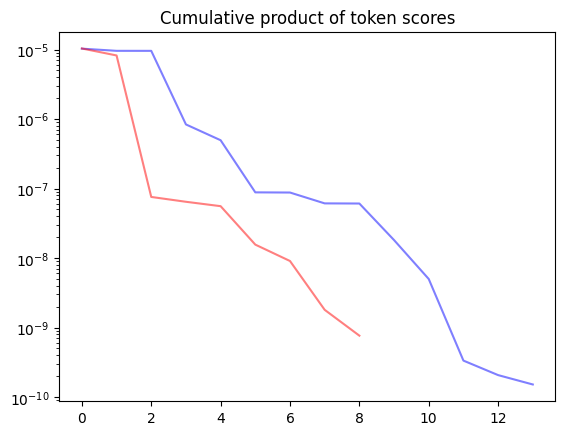

In [119]:
def toline(token_scores_cho):
    mask = (token_scores_cho<1.0) & (token_scores_cho>1e-10)
    x = torch.arange(token_scores_cho.shape[0])[mask]
    y = token_scores_cho[mask]
    return x, y

for i in range(2,3):
    plt.plot(
        *toline(token_scores_cho.cumprod(1)[i]), label='chosen', color='blue', alpha=0.5, linestyle='-')
    plt.plot(
        *toline(token_scores_rej.cumprod(1)[i]), label='rejected', color='red', alpha=0.5, linestyle='-')
plt.yscale('log')
plt.title('Cumulative product of token scores')
    # plt.show()

In [109]:
token_scores_rej.cumprod(1)

tensor([[1.1944e-01, 1.1254e-01, 4.7281e-02,  ..., 1.3629e-11, 1.3629e-11,
         1.3629e-11],
        [9.9292e-01, 9.9267e-01, 8.1496e-01,  ..., 1.3900e-13, 1.3900e-13,
         1.3900e-13],
        [1.0347e-05, 8.2090e-06, 7.5684e-08,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.7515e-01, 5.7310e-02, 8.3216e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.4228e-02, 3.3795e-02, 1.9713e-02,  ..., 5.8981e-13, 5.8982e-13,
         5.8982e-13],
        [9.0299e-01, 8.8824e-01, 8.2070e-01,  ..., 3.5602e-17, 3.5602e-17,
         3.5603e-17]])

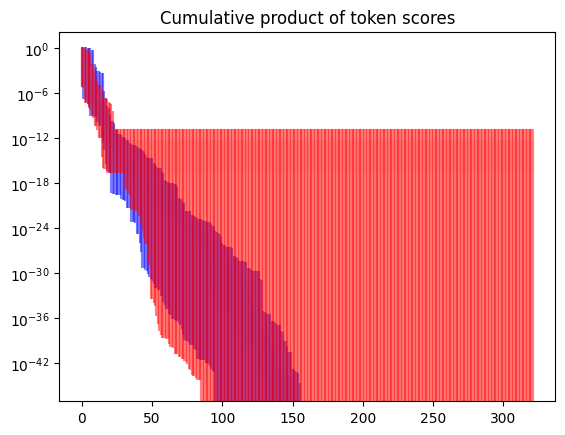

In [76]:
plt.plot(
    torch.arange(token_scores_cho.shape[1]).unsqueeze(0).expand(token_scores_cho.shape[0], -1),
    token_scores_cho.cumprod(1), label='chosen', color='blue', alpha=0.5)
plt.plot(
    torch.arange(token_scores_rej.shape[1]).unsqueeze(0).expand(token_scores_rej.shape[0], -1),
    token_scores_rej.cumprod(1), label='rejected', color='red', alpha=0.5)
plt.yscale('log')
plt.title('Cumulative product of token scores')
plt.show()

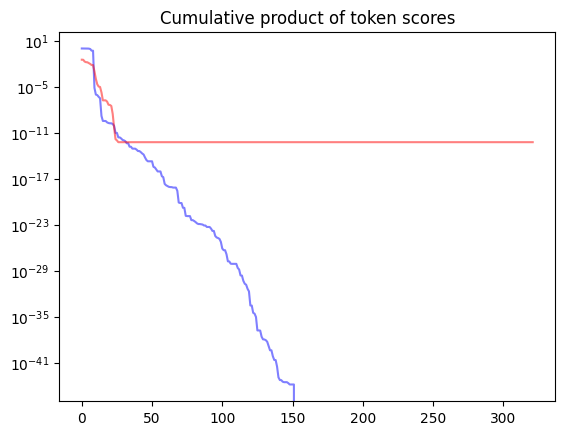

In [77]:
i=4
plt.plot(
    token_scores_cho.cumprod(1)[i], label='chosen', color='blue', alpha=0.5)
plt.plot(
    token_scores_rej.cumprod(1)[i], label='rejected', color='red', alpha=0.5)
plt.yscale('log')
plt.title('Cumulative product of token scores')
plt.show()